In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
)
from imblearn.over_sampling import SMOTE

In [17]:
# Load Dataset
# Ensure 'data_file.csv' is in the same directory as this script.
try:
    df = pd.read_csv('data_file.csv')
    print("Dataset loaded successfully.")
    df.head()
except FileNotFoundError:
    print("Error: 'data_file.csv' not found. Please download it from the Kaggle link and place it in the correct directory.")
    exit()

Dataset loaded successfully.



--- Performing EDA ---


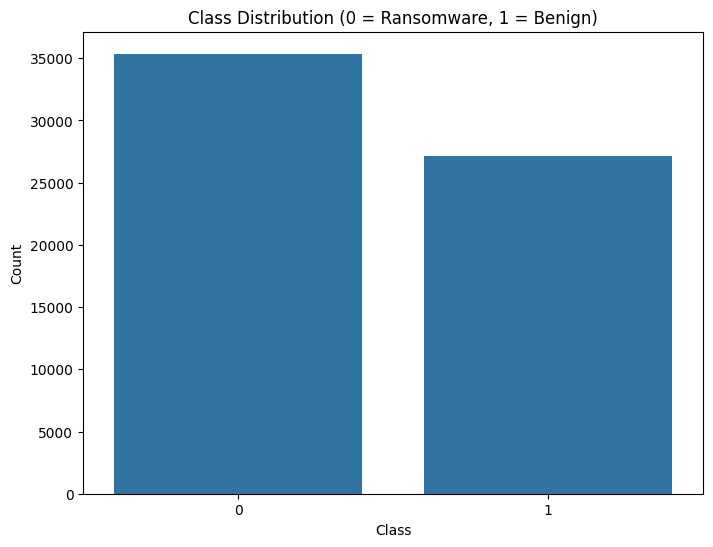

In [3]:
# Exploratory Data Analysis (EDA)

# Class Distribution Analysis
print("\n--- Performing EDA ---")
plt.figure(figsize=(8, 6))
sns.countplot(x='Benign', data=df)
plt.title('Class Distribution (0 = Ransomware, 1 = Benign)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [4]:
# We will define Ransomware as the positive class '1' for our model.
# Currently, Benign is '1'. We will flip this later.
benign_count = df['Benign'].sum()
ransomware_count = len(df) - benign_count
print(f"Number of Benign Samples: {benign_count}")
print(f"Number of Ransomware Samples: {ransomware_count}")
print(f"Imbalance Ratio (Ransomware:Benign): 1:{benign_count/ransomware_count:.2f}")

Number of Benign Samples: 27118
Number of Ransomware Samples: 35367
Imbalance Ratio (Ransomware:Benign): 1:0.77


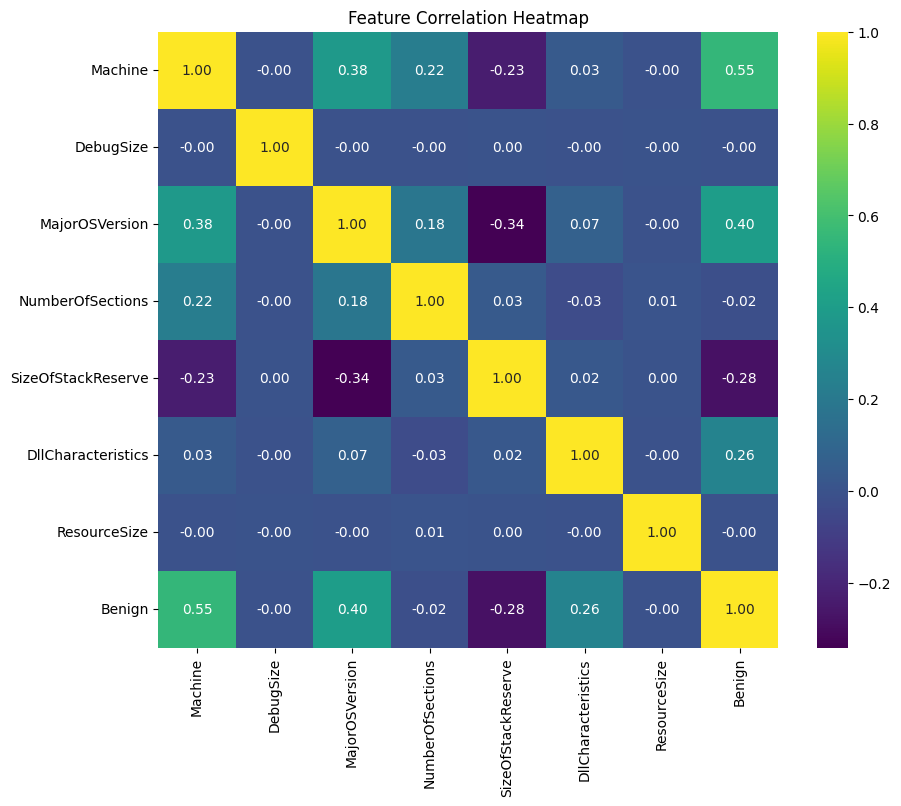

In [5]:
# Feature Behavior - Correlation Heatmap
# Select a subset of features for a cleaner heatmap
features_for_heatmap = [
    'Machine', 'DebugSize', 'MajorOSVersion', 'NumberOfSections',
    'SizeOfStackReserve', 'DllCharacteristics', 'ResourceSize', 'Benign'
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[features_for_heatmap].corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [6]:
# Data Preprocessing & Cleaning
print("\n--- Preprocessing Data ---")
# Cleaning Steps 
# Drop identifiers and handle potential missing values
df_processed = df.drop(['FileName', 'md5Hash'], axis=1)
df_processed.fillna(df_processed.mean(), inplace=True) # Simple imputation

# Define features (X) and target (y)
X = df_processed.drop('Benign', axis=1)
# We want to detect RANSOMWARE, so let's make it the positive class (1)
y = 1 - df_processed['Benign']


--- Preprocessing Data ---


In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [8]:
# Scaling/normalizing technique
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Balancing Strategy 
# Using SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training shape: {X_train_scaled.shape}")
print(f"Resampled training shape: {X_train_resampled.shape}")
print(f"Class distribution after SMOTE: {pd.Series(y_train_resampled).value_counts()}")


Original training shape: (43739, 15)
Resampled training shape: (49514, 15)
Class distribution after SMOTE: Benign
0    24757
1    24757
Name: count, dtype: int64


In [10]:

print("\n--- Training and Evaluating Models ---")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
}

results = {}


--- Training and Evaluating Models ---


In [11]:
# Train and evaluate the models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_pred_proba),
        "Predictions": y_pred,
        "Probabilities": y_pred_proba
    }

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...


In [12]:
# Model Evaluation - 

# Supervised Learning Metrics
print("\n--- Model Comparison ---")
results_df = pd.DataFrame(results).T[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']]
print(results_df)


--- Model Comparison ---
                     Accuracy Precision    Recall  F1-Score   AUC-ROC
Logistic Regression  0.891924  0.919304  0.886899  0.902811  0.939623
Random Forest        0.996959  0.996799  0.997832  0.997315  0.999489
Gradient Boosting    0.991251  0.990883  0.993685  0.992282  0.998593


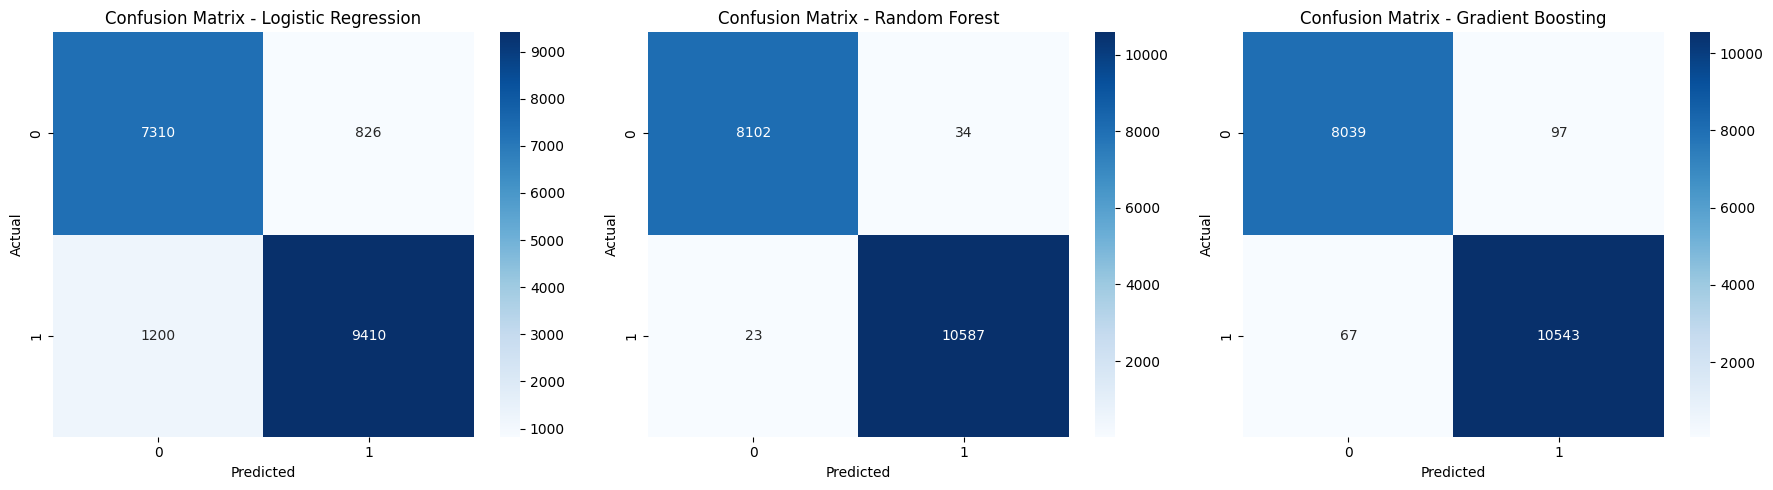

In [27]:
# Confusion Matrices and ROC Curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()
for i, (name, data) in enumerate(results.items()):
    cm = confusion_matrix(y_test, data['Predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_mat.png")
plt.show()

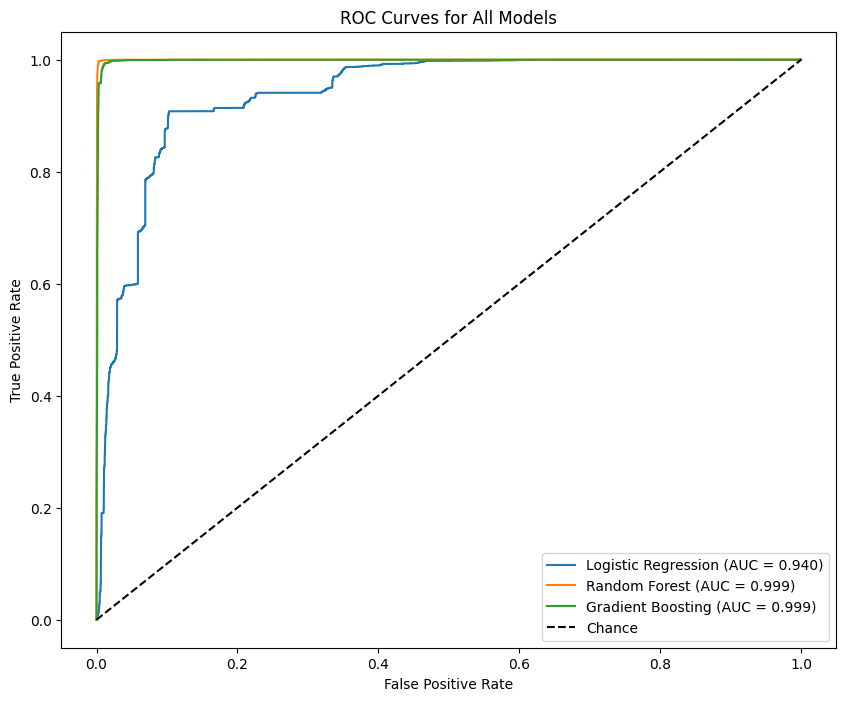

In [26]:
# ROC Curves
plt.figure(figsize=(10, 8))
for name, data in results.items():
    fpr, tpr, _ = roc_curve(y_test, data['Probabilities'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {data['AUC-ROC']:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.savefig("Roc.png")
plt.show()
